In [7]:
%matplotlib notebook

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import pickle
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import qgrid

import torch
import torch.nn as nn
import torch.nn.functional as F

import IPython.display as ipd
from librosa import clicks
from scipy.io import wavfile

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.postprocessing_boeck import activations2beats
from python.models import ModelBoeck

import madmom

In [2]:
print('Torch version: {}'.format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s' % (device))

Torch version: 1.0.0
Device: cpu


## Load data

In [10]:
data = pd.read_csv('../data/data.csv', index_col=0)

## Model

In [4]:
model = ModelBoeck()
model.load_state_dict(torch.load('../models/mb_ballroom_bs-100_fold-0.pt', map_location=device))
model.eval()

ModelBoeck(
  (lstm): LSTM(120, 25, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

In [5]:
def get_audio(file, normalize=False):
    _, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    if normalize:
        signal = signal / np.max(np.abs(signal))
    return signal

def get_sample_rate(file, normalize=False):
    sr, _ = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    return sr

def play_audio(file, normalize=False):
    sr, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    
    if normalize:
        signal = signal / np.max(np.abs(signal))    
        
    return ipd.Audio(signal, rate=sr)

def get_input(file):
    return pickle.load(open('../data/inputs/'+ file + '.npy', 'rb'))

def get_annotations(file):
    return np.loadtxt('../data/annotations/' + file + '.beats', ndmin=2)[:, 0]

def get_predictions(file):
    return np.loadtxt('../data/predictions/' + file + '.beats')

def play_annotations(file, normalize=True):
    sr, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    
    if normalize:
        signal = signal / np.max(np.abs(signal))
        
    metronome = clicks(get_annotations(file), sr=sr, length=len(signal))

    signal = signal + metronome
        
    signal = signal / np.max(np.abs(signal))
        
    return ipd.Audio(signal, rate=sr)

def play_predictions(file, normalize=True):
    sr, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    
    if normalize:
        signal = signal / np.max(np.abs(signal))
        
    metronome = clicks(get_predictions(file), sr=sr, length=len(signal))

    signal = signal + metronome
        
    signal = signal / np.max(np.abs(signal))
        
    return ipd.Audio(signal, rate=sr)


def show_activations(file, model):
    
    input = get_input(file)
    annotations = get_annotations(file)
    predictions = get_predictions(file)

    with torch.no_grad():
        out = model(input.view(1, len(input),-1))

    activations = np.exp(np.array(out[0,1,:]))

    plt.figure(figsize=(9,2))

    plt.plot(activations)
    plt.xlabel('Frames')
    plt.ylabel('Beat activation')
    plt.title('Example no {}: F-measure {:.3f}'.format(index, data.at[index,'f_measure']))

    for ann in annotations:
        plt.axvline(x=ann*100, color='k', linestyle=':', linewidth=1)

    for ann in predictions:
        plt.axvline(x=ann*100, color='r', linestyle=':', linewidth=1)

## Calculate predictions

In [11]:
files = data['file'][data['data_set'] == 2]

start = time.time()
for nr, file in enumerate(files):
    i = files.index[nr]

    print('Evaluate file {} of {}'.format(nr+1, len(files)), end="\r")

    input = get_input(data.at[i,'file'])

    with torch.no_grad():        
        out = model(input.view(1, len(input),-1))

    activations = np.exp(np.array(out[0,1,:]))

    pred_beats = activations2beats(activations)

    np.savetxt('../data/predictions/' + file + '.beats', pred_beats,  fmt='%.2f ')

## Load predictions

In [36]:
predictions = sorted(os.listdir('../data/predictions/fold_'+str(fold)+'/'))
pred_beats = [np.loadtxt('../data/predictions/fold_'+str(fold)+'/'+ pred) for pred in predictions]

In [37]:
p_scores = []
for i, example in enumerate(indices_test):
    pred = pred_beats[i]
    true = annotated_beats[example]
    p_scores.append(madmom.evaluation.beats.pscore(pred,true))

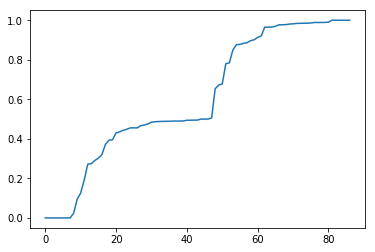

In [9]:
plt.plot(np.sort(p_scores))

In [10]:
np.mean(p_scores)

0.6052823117707538

In [41]:
files = sorted(os.listdir('../data/audio/Ballroom/'))

sr, signal = wavfile.read('../data/audio/Ballroom/' + files[example], mmap=False)

signal = signal/np.max(signal)

metronome = clicks(pred, sr=sr, length=len(signal))

test_signal = signal + metronome

ipd.Audio(test_signal, rate=sr)

Albums-Ballroom_Classics4-09.wav
Albums-Ballroom_Classics4-09.beats


/Users/juliusrichter/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Example

<IPython.core.display.Javascript object>


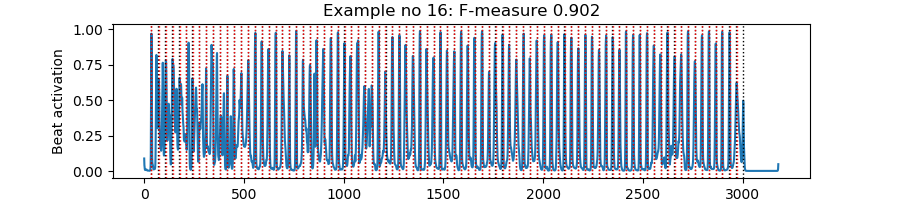

In [23]:
show_activations(data.at[16,'file'], model)

In [17]:
qgrid.show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [22]:
test_input = features[300].view(1, len(features[300]),-1)

with torch.no_grad():
    out = model(test_input)

activations = np.exp(np.array(out[0,1,:]))
    
pred_beats = activations2beats(activations)

## Select fold

In [5]:
fold = 0

indices_test = np.loadtxt('../data/splits/Ballroom/indices_'+str(fold)+'.fold', dtype=np.int64)